In [2]:
# import basic libraries and autograd wrapped numpy
import autograd.numpy as np
from datetime import datetime 
import copy
import math
import sys
sys.path.append('../')
nonlinear_datapath = '../mlrefined_datasets/nonlinear_superlearn_datasets/'
datapath = '../mlrefined_datasets/nonlinear_superlearn_datasets/'

# imports from custom library
from mlrefined_libraries import math_optimization_library as optlib
from mlrefined_libraries import nonlinear_superlearn_library as nonlib
from mlrefined_libraries import basics_library 

# demos for this notebook
regress_plotter = nonlib.nonlinear_regression_demos
classif_plotter = nonlib.nonlinear_classification_visualizer_multiple_panels
static_plotter = optlib.static_plotter.Visualizer()
basic_runner = nonlib.basic_runner
classif_plotter_crossval = nonlib.crossval_classification_visualizer

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

# Exercise 12.1. Complex Fourier representation

$$
w_{0}+\underset{m=1}{\overset{M}{\sum}}\mbox{cos}\left(2\pi mx\right)w_{2m-1}+\mbox{sin}\left(2\pi mx\right)w_{2m}\\
=w_{0}+\underset{m=1}{\overset{M}{\sum}}\frac{1}{2}\left(e^{2\pi imx}+e^{-2\pi imx}\right)w_{2m-1}+\frac{1}{2i}\left(e^{2\pi imx}-e^{-2\pi imx}\right)w_{2m}\\
=w_{0}+\underset{m=1}{\overset{M}{\sum}}\frac{1}{2}\left(w_{2m-1}-iw_{2m}\right)e^{2\pi imx}+\frac{1}{2}\left(w_{2m-1}+iw_{2m}\right)e^{-2\pi imx}\\
=w_{0}+\underset{m=1}{\overset{M}{\sum}}\frac{1}{2}\left(w_{2m-1}-iw_{2m}\right)e^{2\pi imx}+\underset{m=1}{\overset{M}{\sum}}\frac{1}{2}\left(w_{2m-1}+iw_{2m}\right)e^{-2\pi imx}\\
=w_{0}+\underset{m=1}{\overset{M}{\sum}}\frac{1}{2}\left(w_{2m-1}-iw_{2m}\right)e^{2\pi imx}+\underset{m=-1}{\overset{-M}{\sum}}\frac{1}{2}\left(w_{1-2m}+iw_{-2m}\right)e^{2\pi imx}\\
=v_{0}e^{2\pi i0}+\underset{m=1}{\overset{M}{\sum}}v_{m}e^{2\pi imx}+\underset{m=-1}{\overset{-M}{\sum}}v_{m}e^{2\pi imx}=\underset{m=-M}{\overset{M}{\sum}}v_{m}e^{2\pi imx}.
$$



# Exercise 12.2. Combinatorial explosion in monomials

A polynomial unit of degree-$D$ with $N$-dimensional input takes the form

$$f(x_1,x_2,\ldots,x_N)=x_1^{\,j_1}x_2^{\,j_2}\cdots x_{N}^{\,j_N}$$

where $j_1$ through $j_N$ are nonnegative integers and 

$$j_1+j_2+\cdots+j_N \leq D.$$

Defining $i_n = j_n + 1$ for all $1\leq n\leq N$, we want to find the number of tuples $(i_1,i_2,\ldots,i_N)$ satisfying

$$i_1+i_2+\cdots+i_N \leq N+D$$

where $i_1$ through $i_N$ are all positive integers. Note that the number of such tuples is equal to the number of tuples satisfying the equality 

$$i_1+i_2+\cdots+i_N = k$$

summed over all values of $N \leq k \leq N+D$.

To find the number of all positive integer solutions to the equality above, consider a sequence of $k$ ones as shown below

$$1\,\, 1\,\, 1\,\, \cdots 1\,\, 1$$.

Notice, of all the $k-1$ spaces between the consecutive ones, we need to choose $N-1$ of them to place addition signs, and each such configuration then becomes a unique solution to the equation above, giving a total of $\binom{k-1}{N-1} $ solutions.   

Finally, summing over all valid values of $k$ and using the [Hockey-stick identity](https://en.wikipedia.org/wiki/Hockey-stick_identity) we have  


$$\sum_{k=N}^{N+D} \binom{k-1}{N-1} =  \binom{N+D}{N}.$$

This number includes the solution $(j_1,j_2,\ldots,j_N)=(0,0,\ldots,0)$. Therefore, the number of non-constant polynomial units of degree-$D$ can be written simply as


$$\binom{N+D}{N}-1.$$


# Exercise 12.3. Polynomial kernel regression

In [3]:
# This code cell will not be shown in the HTML version of this notebook
# import data
csvname = datapath + 'noisy_sin_sample.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = copy.deepcopy(data[:-1,:])
y = copy.deepcopy(data[-1:,:])

# range of degrees
degrees = [1,3,10]
betas = [10**(-4),10**(-3),10**(-2)]

# loop over degrees and fit
runs = []
for d in degrees:
    # initialize with input/output data
    mylib1 = nonlib.kernel_lib.classic_superlearn_setup.Setup(x,y)

    # perform preprocessing step(s) - especially input normalization
    mylib1.choose_normalizer(name = 'standard')

    # split into training and validation sets
    mylib1.make_train_valid_split(train_portion = 1)

    # choose cost
    mylib1.choose_cost(name = 'least_squares')

    # choose dimensions of fully connected multilayer perceptron layers
    mylib1.choose_kernel(name = 'polys',degree = d,scale = 0)

    # fit an optimization
    mylib1.fit(name = 'newtons_method',max_its = 1,verbose = False,epsilon = 10**(-10))

    # store
    runs.append(copy.deepcopy(mylib1))

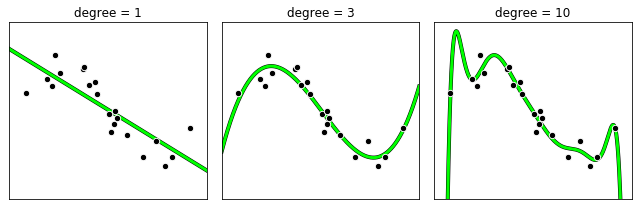

In [4]:
demo = nonlib.kernel_visualizer.Visualizer(csvname)
labels = ['degree = ' + str(d) for d in degrees]
demo.show_regression_runs(runs,labels = labels)

# Exercise 12.4. Kernelize the L2 regularized Least Squares cost

The $\ell_2$ regularized Least Squares cost is given as 

$$g(b,\mathbf{w})=\frac{1}{P}\sum_{p=1}^{P} \left(b+\mathbf{f}_p^T \mathbf{w}-y_p\right)^2 + \lambda \lVert\mathbf{w}\rVert_{2}^{2}$$

Applying the fundamental theorem of linear algebra we may then write $\mathbf{w}$ as $\mathbf{w}=\mathbf{F}\mathbf{z}+\mathbf{r}$ where $\mathbf{F}^T\mathbf{r}=\mathbf{0}$. Substituting into the cost and noting that

$$\mathbf{w}^T \mathbf{w} = \left(\mathbf{F}\mathbf{z}+\mathbf{r}\right)^T \left(\mathbf{F}\mathbf{z}+\mathbf{r}\right) = \mathbf{z}^T\mathbf{F}^T\mathbf{F}\mathbf{z}+\mathbf{r}^T\mathbf{r} = \mathbf{z}^T\mathbf{H}\mathbf{z} + \lVert\mathbf{r}\rVert_{2}^{2},$$ 

denoting $\mathbf{H}=\mathbf{F}^T\mathbf{F}$ as the kernel matrix we may rewrite the above equivalently as 

$$g(b,\mathbf{z},\mathbf{r})= \frac{1}{P}\sum_{p=1}^{P} \left(b+\mathbf{h}_p^T \mathbf{z}-y_p\right)^2 + \lambda\, \mathbf{z}^T\mathbf{H}\mathbf{z} + \lambda \lVert\mathbf{r}\rVert_{2}^{2}.$$

Note that since we are aiming to minimize the quantity above over $\left(b,\mathbf{z},\mathbf{r}\right)$, and since the only term with $\mathbf{r}$ remaining is $\lVert\mathbf{r}\rVert_{2}^{2}$, the optimal value of $\mathbf{r}$ is zero, for otherwise the value of the cost function would be larger than necessary. Therefore we can ignore $\mathbf{r}$ and write the cost function above in kernelized form as  

$$g(b,\mathbf{z})= \frac{1}{P}\sum_{p=1}^{P} \left(b+\mathbf{h}_p^T \mathbf{z}-y_p\right)^2 + \lambda\, \mathbf{z}^T\mathbf{H}\mathbf{z}.$$

# Exercise 12.5. Kernelize the multi-class Softmax cost

The multi-class Softmax cost is given as 

$$g(b_0,\ldots,b_{C-1},\mathbf{w}_0,\ldots,\mathbf{w}_{C-1})=\frac{1}{P}\sum_{p=1}^{P} \text{log}\left(1+\underset{\underset{j\neq y_p}{j=0}}{\overset{C-1}{\sum}}e{}^{\left(b_j-b_{y_p}\right) + \mathbf{f}_{p}^{T}\left(\mathbf{w}_{j}-\mathbf{w}_{y_p}\right)}\right).$$

Rewriting each $\mathbf{w}_j$ as $\mathbf{w}_j=\mathbf{F}\mathbf{z}_j+\mathbf{r}_j$, where $\mathbf{F}^T\mathbf{r}_j=\mathbf{0}$ for all $j$, we can rewrite each $ \mathbf{f}_{p}^{T}\left(\mathbf{w}_{j}-\mathbf{w}_{y_p}\right)$ term as

$$\mathbf{f}_{p}^{T}\left(\mathbf{w}_{j}-\mathbf{w}_{y_p}\right) = \mathbf{f}_{p}^{T}\left(\mathbf{F}\left(\mathbf{z}_j-\mathbf{z}_{y_p}\right) + \left(\mathbf{r}_j-\mathbf{r}_{y_p}\right)\right) =  \mathbf{f}_{p}^{T}\mathbf{F}\left(\mathbf{z}_j-\mathbf{z}_{y_p}\right).$$

And denoting $\mathbf{H}=\mathbf{F}^T\mathbf{F}$, we have that $\mathbf{f}_{p}^{T}\left(\mathbf{w}_{j}-\mathbf{w}_{y_p}\right) =  \mathbf{h}_{p}^{T}\left(\mathbf{z}_j-\mathbf{z}_{y_p}\right)$ and so the cost may be written equivalently as 

$$g(b_0,\ldots,b_{C-1},\mathbf{z}_0,\ldots,\mathbf{z}_{C-1})=\frac{1}{P}\sum_{p=1}^{P} \text{log}\left(1+\underset{\underset{j\neq y_p}{j=0}}{\overset{C-1}{\sum}}e{}^{\left(b_j-b_{y_p}\right) + \mathbf{h}_{p}^{T}\left(\mathbf{z}_{j}-\mathbf{z}_{y_p}\right)}\right).$$

# Exercise 12.6. Regression with the RBF kernel

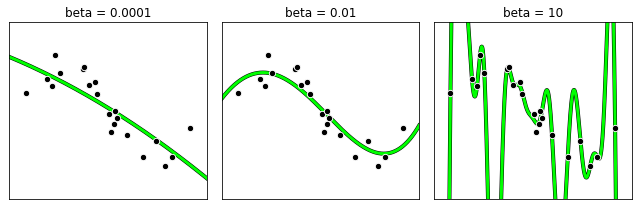

In [6]:
# This code cell will not be shown in the HTML version of this notebook
#### regression example ####
# import data
csvname = datapath + 'noisy_sin_sample.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = copy.deepcopy(data[:-1,:])
y = copy.deepcopy(data[-1:,:])

# range of degrees
betas = [10**(-4),10**(-2),10**(1)]

# loop over degrees and fit
runs = []
for d in betas:
    # initialize with input/output data
    mylib1 = nonlib.kernel_lib.classic_superlearn_setup.Setup(x,y)

    # perform preprocessing step(s) - especially input normalization
    mylib1.choose_normalizer(name = 'standard')

    # split into training and validation sets
    mylib1.make_train_valid_split(train_portion = 1)

    # choose cost
    mylib1.choose_cost(name = 'least_squares')

    # choose dimensions of fully connected multilayer perceptron layers
    mylib1.choose_kernel(name = 'gaussian',beta = d,scale = 0)

    # fit an optimization
    mylib1.fit(name = 'newtons_method',max_its = 1,verbose = False,epsilon = 10**(-10))

    # store
    runs.append(copy.deepcopy(mylib1))
    
# plot
demo = nonlib.kernel_visualizer.Visualizer(csvname)
labels = ['beta = ' + str(d) for d in betas]
demo.show_regression_runs(runs,labels = labels)



# Exercise 12.7. Two-class classification with the RBF kernel

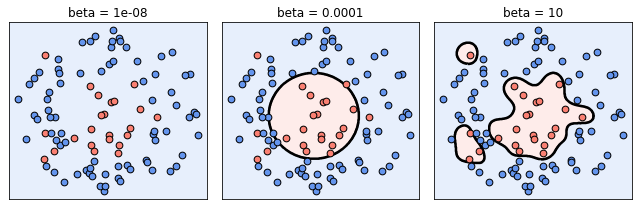

In [7]:

#### two-class classification example ####
# import data
csvname = datapath + 'new_circle_data.csv'

data = np.loadtxt(csvname,delimiter = ',')
x = copy.deepcopy(data[:-1,:])
y = copy.deepcopy(data[-1:,:])

# range of degrees
betas = [10**(-8),10**(-4),10**(1)]

# loop over degrees and fit
runs = []
for d in betas:
    # initialize with input/output data
    mylib1 = nonlib.kernel_lib.classic_superlearn_setup.Setup(x,y)

    # perform preprocessing step(s) - especially input normalization
    mylib1.choose_normalizer(name = 'standard')

    # choose cost
    mylib1.choose_cost(name = 'softmax')

    # choose dimensions of fully connected multilayer perceptron layers
    mylib1.choose_kernel(name = 'gaussian',beta = d,scale = 0)

    # fit an optimization
    mylib1.fit(name = 'newtons_method',max_its = 5,verbose = False,epsilon = 10**(-10))

    # store
    runs.append(copy.deepcopy(mylib1))
    
# plot results
demo = nonlib.kernel_visualizer.Visualizer(csvname)
labels = ['beta = ' + str(d) for d in betas]
demo.show_twoclass_runs(runs,labels = labels)

# Exercise 12.8. Multi-class classification with the RBF kernel

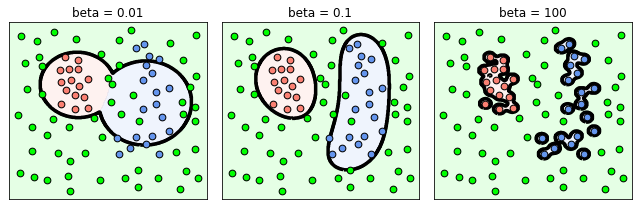

In [11]:
### multi-class classification ###
# import data
csvname = datapath + '2eggs_multiclass.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = copy.deepcopy(data[:-1,:])
y = copy.deepcopy(data[-1:,:])

# range of degrees
betas = [10**(-2),10**(-1),10**(2)]

# loop over degrees and fit
runs = []
for d in betas:
    # initialize with input/output data
    mylib1 = nonlib.kernel_lib.classic_superlearn_setup.Setup(x,y)

    # perform preprocessing step(s) - especially input normalization
    mylib1.choose_normalizer(name = 'standard')

    # choose cost
    mylib1.choose_cost(name = 'multiclass_softmax')

    # choose dimensions of fully connected multilayer perceptron layers
    mylib1.choose_kernel(name = 'gaussian',beta = d,scale = 0)

    # fit an optimization
    mylib1.fit(name = 'newtons_method',max_its = 5,verbose = False,epsilon = 10**(-5))

    # store
    runs.append(copy.deepcopy(mylib1))
    
# plot results
demo = nonlib.kernel_visualizer.Visualizer(csvname)
labels = ['beta = ' + str(d) for d in betas]
demo.show_multiclass_runs(runs,labels = labels)

# Exercise 12.9. Polynomial kernels for arbitrary degree and input dimension

# Exercise 12.10. An infinite-dimensional feature transformation

$$h_{i,j}=f_1(x_i)\,f_1(x_j) + f_2(x_i)\,f_2(x_j) + f_3(x_i)\,f_3(x_j) + \cdots \\
= \left(e^{-\beta x_{i}^{2}}\sqrt{\frac{\left(2\beta\right)^{0}}{\left(0\right)!}}x_{i}^{0} \,e^{-\beta x_{j}^{2}}\sqrt{\frac{\left(2\beta\right)^{0}}{\left(0\right)!}}x_{j}^{0}\right) + \left(e^{-\beta x_{i}^{2}}\sqrt{\frac{\left(2\beta\right)^{1}}{\left(1\right)!}}x_{i}^{1} \,e^{-\beta x_{j}^{2}}\sqrt{\frac{\left(2\beta\right)^{1}}{\left(1\right)!}}x_{j}^{1}\right) + \left(e^{-\beta x_{i}^{2}}\sqrt{\frac{\left(2\beta\right)^{2}}{\left(2\right)!}}x_{i}^{2} \,e^{-\beta x_{j}^{2}}\sqrt{\frac{\left(2\beta\right)^{2}}{\left(2\right)!}}x_{j}^{2}\right) + \cdots \\
=e^{-\beta x_{i}^{2}}e^{-\beta x_{j}^{2}}\left(\frac{\left(2\beta\right)^{0}}{\left(0\right)!} x_{i}^{0} x_{j}^{0} + \frac{\left(2\beta\right)^{1}}{\left(1\right)!} x_{i}^{1} x_{j}^{1} + \frac{\left(2\beta\right)^{2}}{\left(2\right)!} x_{i}^{2} x_{j}^{2} + \cdots\right)\\
=e^{-\beta x_{i}^{2}}e^{-\beta x_{j}^{2}}e^{\,2\beta x_{i}x_{j}} = e^{\,-\beta \left(x_{i}^{2}+ x_{j}^{2}-2 x_{i}x_{j}\right)}=e^{\,-\beta \left(x_{i}- x_{j}\right)^2}
$$

# Exercise 12.11. Fourier kernel for vector-valued input


Like the multidimensional polynomial basis element 
with the complex exponential notation for a general $N$ dimensional
input each Fourier basis element takes the form $f_{\mathbf{m}}\left(\mathbf{x}\right)=e^{2\pi im_{1}x_{1}}e^{2\pi im_{2}x_{2}}\cdots e^{2\pi im_{N}x_{N}}=e^{2\pi i\mathbf{m}^{T}\mathbf{x}}$
where $\mathbf{m}=\left[\begin{array}{cccc}
m_{1} & m_{2} & \cdots & m_{N}\end{array}\right]^{T}$, a product of one dimensional basis elements. Further a 'degree $D$'
sum contains all such basis elements where $-D\leq m_{1},\,m_{2},\,\cdots,\,m_{N}\leq D$,
and one may deduce that there are $M=\left(2D+1\right)^{N}-1$ non
constant basis elements in this sum. 

The the corresponding $\left(i,j\right)$th entry of the kernel matrix
in this instance takes the form

\begin{equation}
\mathbf{H}_{ij}=\mathbf{f}{}_{i}^{T}\overline{\mathbf{f}_{j}}=\left(\underset{-D\leq m_{1},\,m_{2},\,\cdots,\,m_{N}\leq D}{\sum}e^{2\pi i\mathbf{m}^{T}\left(\mathbf{x}_{i}-\mathbf{x}_{j}\right)}\right)-1.
\end{equation}

Since $e^{a+b}=e^{a}e^{b}$ we may write each summand above as $e^{2\pi i\mathbf{m}^{T}\left(\mathbf{x}_{i}-\mathbf{x}_{j}\right)}=\underset{n=1}{\overset{N}{\prod}}e^{2\pi im_{n}\left(x_{in}-x_{jn}\right)}$,
and the entire summation as \noindent
\begin{equation}
\underset{-D\leq m_{1},\,m_{2},\,\cdots,\,m_{N}\leq D}{\sum}\,\,\,\underset{n=1}{\overset{N}{\prod}}e^{2\pi im_{n}\left(x_{in}-x_{jn}\right)}.
\end{equation}
Finally one can show that the above can be written simply as \noindent
\begin{equation}
\underset{-D\leq m_{1},\,m_{2},\,\cdots,\,m_{N}\leq D}{\sum}\,\,\,\underset{n=1}{\overset{N}{\prod}}e^{2\pi im_{n}\left(x_{in}-x_{jn}\right)}=\underset{n=1}{\overset{N}{\prod}}\left(\underset{m=-D}{\overset{D}{\sum}}e^{2\pi im\left(x_{in}-x_{jn}\right)}\right).
\end{equation}
Since we already have that $\underset{m=-D}{\overset{D}{\sum}}e^{2\pi im\left(x_{in}-x_{jn}\right)}=\frac{\sin\left(\left(2D+1\right)\pi\left(x_{in}-x_{jn}\right)\right)}{\sin\left(\pi\left(x_{in}-x_{jn}\right)\right)}$,
the $\left(i,j\right)$th entry of the kernel matrix can easily be
calculated as \noindent
\begin{equation}
\mathbf{H}_{ij}=\underset{n=1}{\overset{N}{\prod}}\frac{\mbox{sin}\left(\left(2D+1\right)\pi\left(x_{in}-x_{jn}\right)\right)}{\mbox{sin}\left(\pi\left(x_{in}-x_{jn}\right)\right)}-1.
\end{equation}

# Exercise 12.12. Kernels and a cancer dataset

Below - via a backend package organized into coherent modules - we perform regularization based cross validation using a Gaussian kernel, ranging over the hyperparameter $\beta$.

In [17]:
# load in data
datapath = '../mlrefined_datasets/superlearn_datasets/'
data = np.loadtxt(datapath + 'breast_cancer_data.csv',delimiter = ',')
x = copy.deepcopy(data[:-1,:])
y = copy.deepcopy(data[-1:,:])

# initialize with input/output data
mylib1 = nonlib.kernel_lib_regularized.classic_superlearn_setup.Setup(x,y)

# split into training and testing sets
mylib1.make_train_valid_split(train_portion = 0.8)

# perform preprocessing step(s) - especially input normalization
mylib1.choose_normalizer(name = 'standard')
mylib1.choose_kernel(name = 'gaussian',beta = 2,scale = 0.1)
mylib1.choose_cost(name = 'softmax',lam=0)
mylib1.w_init = mylib1.initializer()

# run 
w_init = mylib1.initializer()
betas = np.linspace(0.01,1,50)
j=0
for beta in betas:    
    # choose dimensions of fully connected multilayer perceptron layers
    mylib1.choose_kernel(name = 'gaussian',beta = beta,scale = 0.1)

    # choose cost
    mylib1.choose_cost(name = 'softmax',lam=0)

    # fit an optimization
    mylib1.fit(name = 'newtons_method',max_its = 1,verbose = False,epsilon = 10**(-10),w_init=w_init)

In [18]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

def show_history(run):
    # initialize figure
    fig = plt.figure(figsize = (10,4))

    # create subplot with 1 panel
    gs = gridspec.GridSpec(1, 1) 
    ax = plt.subplot(gs[0]); 

    # colors
    colors = [[0,0.7,1],[1,0.8,0.5]]

    # plot test cost function history
    train_history = run.train_count_histories
    ax.plot(betas,train_history,linewidth = 3*(0.8)**(0),color = colors[0],label = 'training') 

    val_history = run.valid_count_histories
    ax.plot(betas,val_history,linewidth = 3*(0.8)**(0),color = colors[1],label = 'validation') 

    # clean up panel / axes labels
    xlabel = r'$\beta$ value'
    ylabel = 'misclassifications'
    ax.set_xlabel(xlabel,fontsize = 14)
    ax.set_ylabel(ylabel,fontsize = 14,rotation = 90,labelpad = 25)
    title = 'misclassification history'
    ax.set_title(title,fontsize = 18)
    
    plt.show()

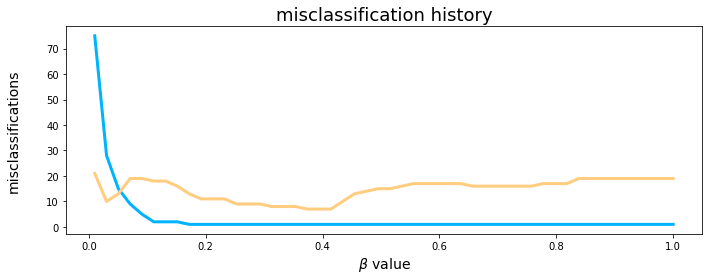

In [19]:
show_history(mylib1)